# **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import sklearn
import json
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Loading Data**

In [4]:
from google.colab import files
data_to_load = files.upload()

Saving train.json to train (1).json


In [5]:
with open('train.json') as data_file:    
    train = pd.read_json(data_file)

# **Exploring data**

In [6]:
train.shape

(39774, 3)

In [7]:
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [9]:
train.isnull().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

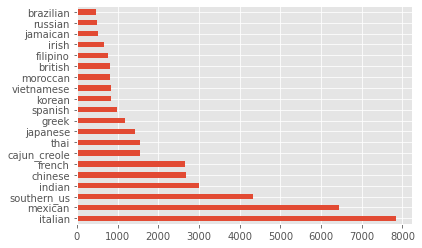

In [10]:
train['cuisine'].value_counts().plot(kind='barh', grid='true')

**Count most frequent ingredients of each cuisine**

In [11]:
from collections import Counter
counters = {}
for cuisine in train['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (train['cuisine'] == cuisine)
    for ingredients in train[indices]['ingredients']:
        counters[cuisine].update(ingredients)

**Total number of ingredients** 

In [12]:
total_ingredients = 0
for cuisine in train['cuisine'].unique():
    total_ingredients += sum(counters[cuisine].values()) 
total_ingredients

428275

**The average number of ingredients per recipe**

In [13]:
int(total_ingredients/train.shape[0])

10

**Top 10 ingredients of each cuisine**

In [14]:
top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
greek,salt,olive oil,dried oregano,garlic cloves,feta cheese crumbles,extra-virgin olive oil,fresh lemon juice,ground black pepper,garlic,pepper
southern_us,salt,butter,all-purpose flour,sugar,large eggs,baking powder,water,unsalted butter,milk,buttermilk
filipino,salt,garlic,water,onions,soy sauce,pepper,oil,sugar,carrots,ground black pepper
indian,salt,onions,garam masala,water,ground turmeric,garlic,cumin seed,ground cumin,vegetable oil,oil
jamaican,salt,onions,water,garlic,ground allspice,pepper,scallions,dried thyme,black pepper,garlic cloves
spanish,salt,olive oil,garlic cloves,extra-virgin olive oil,onions,water,tomatoes,ground black pepper,red bell pepper,pepper
italian,salt,olive oil,garlic cloves,grated parmesan cheese,garlic,ground black pepper,extra-virgin olive oil,onions,water,butter
mexican,salt,onions,ground cumin,garlic,olive oil,chili powder,jalapeno chilies,sour cream,avocado,corn tortillas
chinese,soy sauce,sesame oil,salt,corn starch,sugar,garlic,water,green onions,vegetable oil,scallions
british,salt,all-purpose flour,butter,milk,eggs,unsalted butter,sugar,onions,baking powder,large eggs


**Concatenate ingredients to a single string**

In [15]:
train['all_ingredients'] = train['ingredients'].map(",".join)
train.head()

,id,cuisine,ingredients,all_ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce,black olives,grape tomatoes,ga..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour,ground pepper,salt,tomatoes,ground..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs,pepper,salt,mayonaise,cooking oil,green c..."
3,22213,indian,"[water, vegetable oil, wheat, salt]","water,vegetable oil,wheat,salt"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","black pepper,shallots,cornflour,cayenne pepper..."


**Unique ingredients in top 10 ingredients of each cuisine**

In [16]:
unique_ingredients = np.unique(top10.values.ravel())
unique_ingredients

array(['all-purpose flour', 'avocado', 'baking powder', 'baking soda',
       'black pepper', 'butter', 'buttermilk', 'cachaca',
       'cajun seasoning', 'carrots', 'cayenne pepper', 'chili powder',
       'coconut milk', 'corn starch', 'corn tortillas', 'cumin seed',
       'dried oregano', 'dried thyme', 'eggs', 'extra-virgin olive oil',
       'feta cheese crumbles', 'fish sauce', 'fresh lemon juice',
       'fresh lime juice', 'garam masala', 'garlic', 'garlic cloves',
       'ginger', 'grated parmesan cheese', 'green bell pepper',
       'green onions', 'ground allspice', 'ground black pepper',
       'ground cinnamon', 'ground cumin', 'ground ginger',
       'ground turmeric', 'jalapeno chilies', 'large eggs', 'lime',
       'milk', 'mirin', 'oil', 'olive oil', 'onions', 'paprika', 'pepper',
       'potatoes', 'red bell pepper', 'rice vinegar', 'sake', 'salt',
       'scallions', 'sesame oil', 'sesame seeds', 'shallots',
       'sour cream', 'soy sauce', 'sugar', 'tomatoes', 'un

Number of unique ingredients

In [17]:
len(unique_ingredients)

63

**The frequency of top 10 ingredients in all cuisine** 

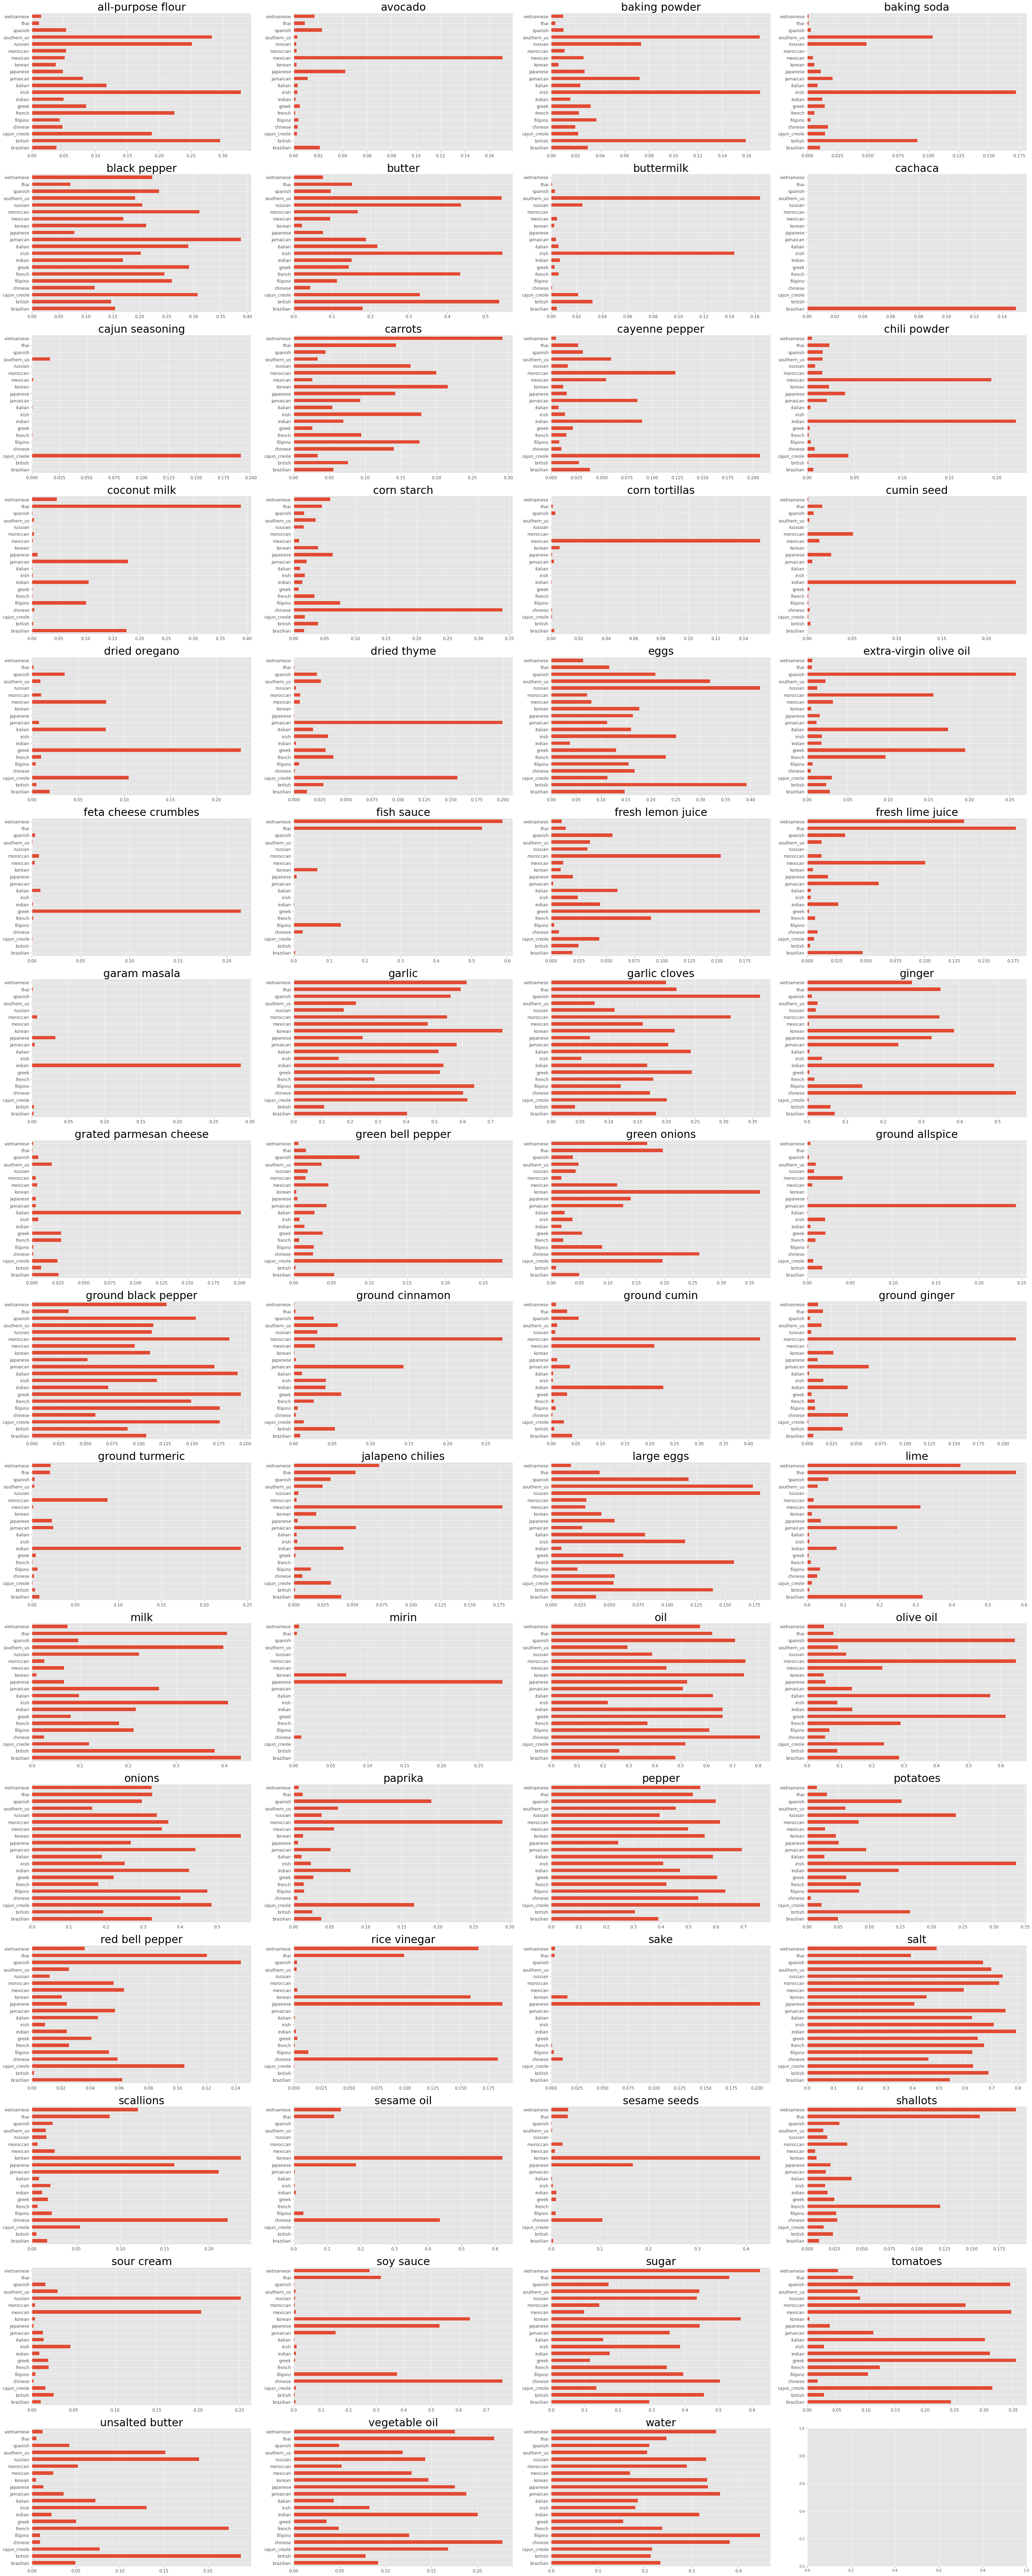

In [18]:
plt.rcParams['axes.titlesize'] = 30
fig, axes = plt.subplots(16, 4, figsize=(40, 100), constrained_layout=True)
for ingredient, ax_index in zip(unique_ingredients, range(64)):
    indices = train['all_ingredients'].str.contains(ingredient)
    relative_freq = (train[indices]['cuisine'].value_counts() / train['cuisine'].value_counts())
    relative_freq.plot(kind='barh', ax=axes.ravel()[ax_index], fontsize=12, title=ingredient)

We can see that some ingredients having high degree of uniqueness, such as:
* avocado (mexican)
* cachaca (brazilian)
* cajun seasoning (cajun_creole)
* corn tortillas (mexican)
* cumin seed (indian)
* feta cheese crumbles (greek)
* fish sauce (vietnamese, thai)

In contrast, there are some ingredients quite common, such as:
* black pepper
* butter
* carrots
* eggs
* garlic
* garlic cloves
* milk 
* oil
* salt



# **Data Transformation**

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

In [20]:
cv = CountVectorizer()
x = cv.fit_transform(train['all_ingredients'].values)
x.shape

(39774, 3010)

In [21]:
print(list(cv.vocabulary_.keys())[:10])

['romaine', 'lettuce', 'black', 'olives', 'grape', 'tomatoes', 'garlic', 'pepper', 'purple', 'onion']


**Encoding the labels that represent the cuisine of each recipe**

In [22]:
enc = LabelEncoder()
y = enc.fit_transform(train.cuisine)

In [23]:
enc.classes_

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object)

In [24]:
y[:5]

array([ 6, 16,  4,  7,  7])

**Splitting the dataset**

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# **Logistic regression**

In [26]:
from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
# xtrain_norm = sc.fit_transform(x_train)
logistic = LogisticRegression(max_iter=4000)
logistic.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
logistic.score(x_test, y_test)

0.7800125707102451

**ROC curve**

In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [29]:
lr = logistic.predict_proba(x_test)

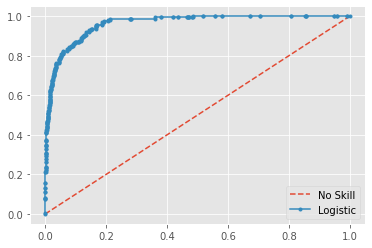

In [30]:
ns_probs = [0.0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label=1)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr[:,1], pos_label=1)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.legend()
plt.show()

# **One Vs Rest Classifier**

In [31]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [66]:
ovrc = OneVsRestClassifier(SVC(probability=True), n_jobs=-1)
ovrc.fit(x_train,y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=-1)

In [67]:
ovrc.score(x_test, y_test)

0.7928346951602766

In [34]:
y_ovrc = ovrc.predict_proba(x_test)

**ROC curve**

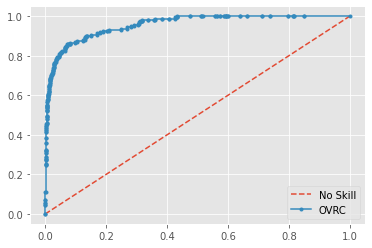

In [36]:
ovrc_fpr, ovrc_tpr, _ = roc_curve(y_test, y_ovrc[:,1], pos_label=1)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(ovrc_fpr, ovrc_tpr, marker='.', label='OVRC')
plt.legend()
plt.show()

# **Random Forest Classifier**

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [39]:
rf.score(x_test, y_test)

0.7478315524827153

In [40]:
y_rf = rf.predict_proba(x_test)

**ROC curve**

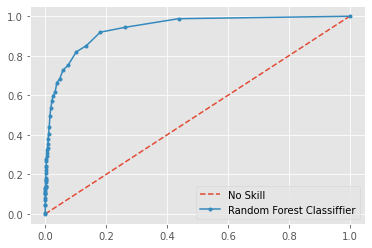

In [41]:
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_rf[:,1], pos_label=1)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest Classiffier')
plt.legend()
plt.show()

# **KNN Classifier**

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [44]:
knn.score(x_test, y_test)

0.6271527341294784

In [45]:
y_knn = knn.predict_proba(x_test)

**ROC curve**

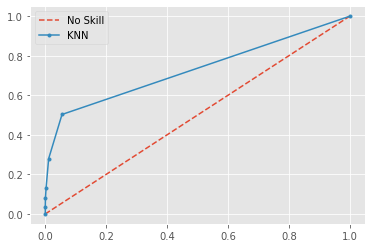

In [46]:
knn_fpr, knn_tpr, _ = roc_curve(y_test, y_knn[:,1], pos_label=1)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')
plt.legend()
plt.show()

# **Calibrated SVM Classifier**

In [57]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [58]:
 svm = LinearSVC()
 clf = CalibratedClassifierCV(svm) 
 clf.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv=None, method='sigmoid')

In [59]:
clf.score(x_test, y_test)

0.777372721558768

In [64]:
y_svm = clf.predict_proba(x_test)

**ROC curve**

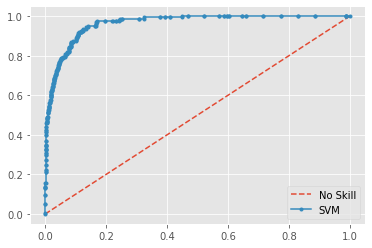

In [65]:
svm_fpr, svm_tpr, _ = roc_curve(y_test, y_svm[:,1], pos_label=1)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
plt.legend()
plt.show()